In [1]:
import numpy as np
from matplotlib import pyplot as plt
import glob
from scipy.stats import kendalltau

In [2]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

plt.style.use('seaborn')

nice_fonts = {
        # Use LaTeX to write all text
        "text.usetex": True,
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 16,
        "font.size": 16,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 14,
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
}

matplotlib.rcParams.update(nice_fonts)

In [3]:
flist = sorted(glob.glob('./tau_*'))

In [4]:
tau_sink = []
for f in flist:
    tau_sink.append(np.genfromtxt(f))

In [5]:
flist = sorted(glob.glob('./Acc_*'))
acc_sink = []
for f in flist:
    acc_sink.append(np.genfromtxt(f))

In [6]:
demos = np.arange(1,1950,50,dtype='int')

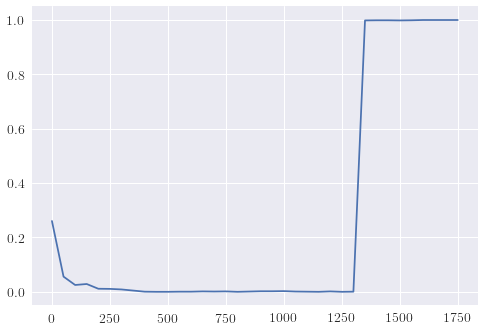

In [7]:
plt.plot(demos[0:len(acc_sink)],np.sum(np.vstack(acc_sink),axis=1)/1950)
plt.show()

In [8]:
# Baseline (no generalisation)
baseline = (demos*1.0 + (1950-demos)*0)/720

from itertools import permutations 
obj_id_list = []
for r in range(2,7):
    obj_id_list = obj_id_list + list(permutations(range(0, 6),r=r))
    
perms = np.ones((len(obj_id_list),6))*100
seq_len = []
for j,obj_idx in enumerate(obj_id_list):
    seq_len.append(len(obj_idx))
    perms[j,0:len(obj_idx)] = obj_idx
    

In [9]:
baseline_tau = []
baseline_acc = []
for d in demos:
    perms_copy = np.copy(perms)
    perms_shuffled = np.copy(perms_copy[d:,:])
    np.random.shuffle(perms_shuffled)
    perms_copy[d:,:] = perms_shuffled
    tau_list = []
    acc_list = []
    for k in range(perms.shape[0]):
        tau,p = kendalltau(perms[k,:seq_len[k]],perms_copy[k,:seq_len[k]])
        tau_list.append(tau)
        acc = np.array_equal(perms[k,::seq_len[k]],perms_copy[k,::seq_len[k]])
        acc_list.append(acc)
    baseline_tau.append(tau_list)
    baseline_acc.append(acc_list)
    
hists_baseline = []
for t in np.vstack(baseline_tau):
    h,_ = np.histogram(t,np.linspace(-1,1,10))
    hists_baseline.append(h)

In [10]:
tmean = np.array([np.mean(t) for t in tau_sink])
tstd = np.array([np.std(t) for t in tau_sink])
num_tests = np.array([t.shape[0] for t in tau_sink])

In [11]:
bmean = np.array([np.mean(t) for t in baseline_tau])
bstd = np.array([np.std(t) for t in baseline_tau])

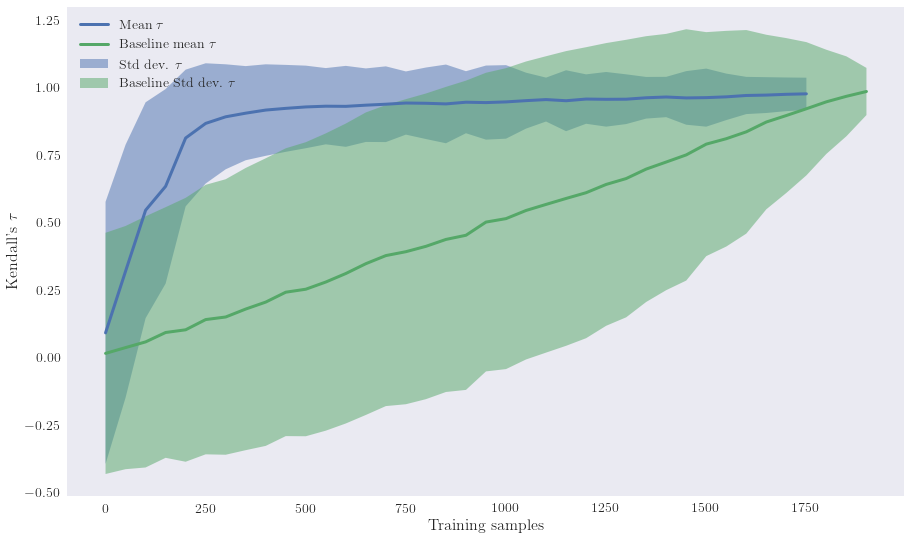

In [12]:
plt.figure(figsize=(15,9))
plt.plot(demos[0:len(tmean)],tmean,linewidth=3,label='Mean $\\tau$')
plt.fill_between(demos[0:len(tmean)],tmean-tstd,tmean+tstd,alpha=0.5,label='Std dev. $\\tau$')
plt.plot(demos[0:len(bmean)],bmean,linewidth=3,label='Baseline mean $\\tau$')
plt.fill_between(demos[0:len(bmean)],bmean-bstd,bmean+bstd,alpha=0.5,label='Baseline Std dev. $\\tau$')

# plt.plot(demos,baseline,'--',linewidth=3,label='No Generalisation')
plt.xlabel('Training samples')
plt.ylabel('Kendall\'s $\\tau$')
plt.grid()
plt.legend()
plt.show()

In [13]:
hists = []
for t in tau_sink:
    h,_ = np.histogram(t,np.linspace(-1,1,10))
    hists.append(h)

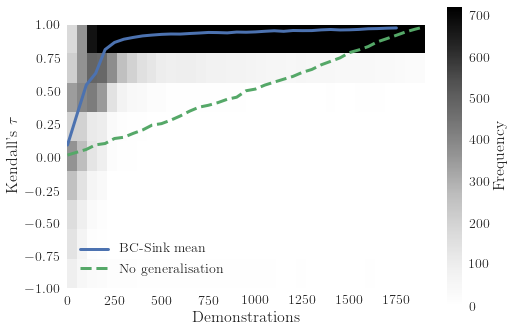

In [14]:
# plt.figure(figsize=(15,5))
# plt.subplot(2,1,1)
plt.imshow(np.vstack(hists).T,extent=(1,demos[-1],-1,1),aspect=700,origin='lower',vmin=0,vmax=720,interpolation='None')
plt.plot(demos[0:len(tmean)],tmean,linewidth=3,label='BC-Sink mean')
# plt.fill_between(demos[0:len(tmean)],tmean-tstd,tmean+tstd,alpha=0.5,label='Std dev. $\\tau$')
plt.plot(demos,bmean,'--',linewidth=3,label='No generalisation')
# plt.fill_between(demos[0:len(bmean)],bmean-bstd,bmean+bstd,alpha=0.5,label='Baseline Std dev. $\\tau$')
plt.colorbar(label='Frequency')
plt.legend(loc='lower left')
plt.grid()
plt.ylabel('Kendall\'s $\\tau$')
plt.xlabel('Demonstrations')

# plt.subplot(2,1,2)
# plt.imshow(np.vstack(hists_baseline).T,extent=(1,720,-1,1),aspect=200,origin='lower',vmin=0,vmax=720)
# plt.colorbar()
plt.savefig('Generalisation_subsets.pdf')
plt.show()

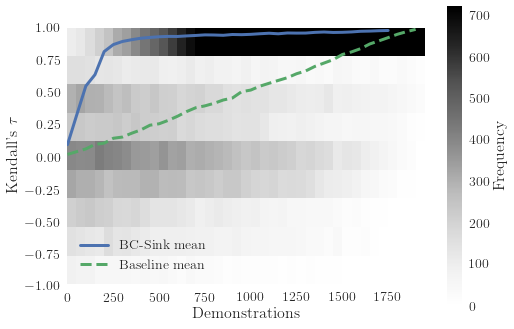

In [15]:
# plt.figure(figsize=(15,5))
plt.imshow(np.vstack(hists_baseline).T,extent=(1,1950,-1,1),aspect=700,origin='lower',vmin=0,vmax=720,interpolation='None')
plt.plot(demos[0:len(tmean)],tmean,linewidth=3,label='BC-Sink mean')
plt.plot(demos[0:len(bmean)],bmean,'--',linewidth=3,label='Baseline mean')
plt.colorbar(label='Frequency')
plt.legend(loc='lower left')
plt.grid()
plt.ylabel('Kendall\'s $\\tau$')
plt.xlabel('Demonstrations')
plt.show()

In [16]:
import seaborn as sns
# sns.set_context('paper')

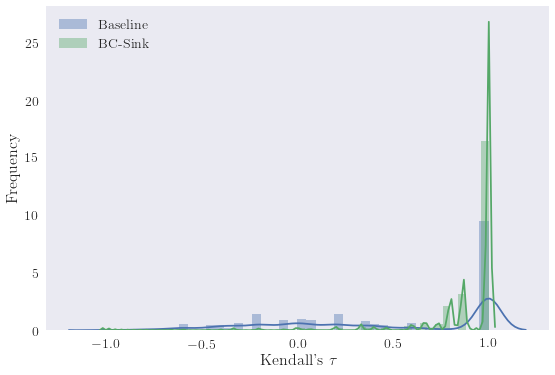

In [17]:
sns.distplot(np.concatenate(baseline_tau[0:len(tau_sink)]).ravel(),label='Baseline')
sns.distplot(np.concatenate(tau_sink).ravel(),label='BC-Sink')
plt.grid()
plt.xlabel('Kendall\'s $\\tau$')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.savefig('kde_bc.pdf')
plt.show()